In [342]:
import pandas as pd
import numpy as np
import jupyter_utils as ju
ju.jupyter_setup()
import os
from evaluation_and_tracking import IDPerformanceTracker
import torch
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.linear_model import LinearRegression, LogisticRegression
from utils.utils import FocalLoss
pd.options.display.float_format = '{:.4f}'.format
from torch.nn import BCELoss
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve

# loss_func = FocalLoss(gamma=0, exclude_outliers=0)
loss_func = BCELoss()
modalities = [
    "cough",
    "counting",
    "breath",
    "vowel"
]
modality_dict = {
    "cough":"combined_coughs",
    "counting":"combined_speech",
    "breath":"combined_breaths",
    "vowel":"combined_vowels"
}

C:\Michi\acoustic_covid_detection\python


In [398]:
ID_PERFORMANCE_TRACKING = "noMetadataMIL_v2.pickle"
# ID_PERFORMANCE_TRACKING = "metadata_mil.pickle"
# ID_PERFORMANCE_TRACKING = "baseline_models.pickle"
# ID_PERFORMANCE_TRACKING = "correct_metadata.pickle"

use_modalities = [
    "combined_coughs",
    "combined_speech",
   "combined_breaths",
   "combined_vowels"
]

In [399]:
id_performance = IDPerformanceTracker(ID_PERFORMANCE_TRACKING)
id_performance.df = id_performance.load()


# for modality in use_modalities:
id_performance.df = id_performance.df[id_performance.df.rec_type.isin(use_modalities)]

total_eval_data = id_performance.df[id_performance.df.set_type == "eval"]
total_test_data = id_performance.df[id_performance.df.set_type == "test"]

seeds = list(id_performance.df.seed.unique())
recording_types = list(total_eval_data.rec_type.unique())
print(f"Seeds used: {seeds}")
print(f"Recording Types used: {recording_types}")

# make sure, that there are even numbers for all 5 seeds, otherwise it did not record correctly
total_eval_data.seed.value_counts(), total_test_data.seed.value_counts()

Seeds used: [66445511337, 55555555, 3213213211, 215674, 99468865]
Recording Types used: ['combined_vowels', 'combined_speech', 'combined_coughs', 'combined_breaths']


(215674         1022
 55555555       1014
 3213213211     1009
 99468865        988
 66445511337     984
 Name: seed, dtype: int64,
 66445511337    1846
 55555555       1846
 3213213211     1846
 215674         1846
 99468865       1846
 Name: seed, dtype: int64)

In [400]:
df = ju.get_mean_prediction_and_loss(id_performance.df)
# df = ju.only_use_last_prediction_and_loss(id_performance)
df = ju.apply_sigmoid(df)
df

,ID,label,loss,prediction,rec_type,seed,set_type
0,01OCEf1yB4czsq8ygRoT51s96Ba2,0.0000,0.6914,0.4991,combined_vowels,66445511337,eval
1,0gB18cWHioTobGuU3qVE0QV5mBN2,0.0000,0.6826,0.4947,combined_vowels,66445511337,eval
2,0Ha52POVIxTKEPqI1eGpIoMHUd52,0.0000,0.6922,0.4995,combined_vowels,66445511337,eval
3,0HIgO2EhOOW1msCbEw1kC8Qsx6D3,0.0000,0.6835,0.4951,combined_vowels,66445511337,eval
4,0W7xMFW538WmDghkiujx2v4xVnt2,0.0000,0.6823,0.4945,combined_vowels,66445511337,eval
...,...,...,...,...,...,...,...
14242,ZNTuppbDaCNybeDYGmyjJeYr93s1,0.0000,0.7096,0.5081,combined_breaths,99468865,test
14243,zOmz0TaNdmQfF2jUFkqUKuNa80m1,0.0000,0.7047,0.5057,combined_breaths,99468865,test
14244,Zs7tQ487P7hws3ur1TG53aiF0eC2,0.0000,0.7048,0.5058,combined_breaths,99468865,test
14245,Zs8oTVcUPTc8pk9UES7sFEhRDxX2,0.0000,0.7034,0.5051,combined_breaths,99468865,test


In [401]:
full_metadata = pd.read_csv("data/Coswara_processed/full_meta_data.csv")
full_metadata = full_metadata.rename(columns={"user_id":"ID"})
for modality in modalities:
    desired_columns = [col for col in full_metadata.columns if (modality in col) and ("duration" in col) and ("trimmed" in col)]
    col_name = f"{modality_dict[modality]}_total_duration"
    full_metadata[col_name] = full_metadata[desired_columns].sum(axis=1)
desired_columns = [col for col in full_metadata.columns if ("duration" in col) and ("total" in col)]
desired_columns += ["ID", "age", "country", "gender", "type_of_covid_test"]
relevant_metadata = full_metadata[desired_columns]
merged_df = df.merge(relevant_metadata, on='ID', how='left')
merged_df

,ID,label,loss,prediction,rec_type,seed,set_type,combined_coughs_total_duration,combined_speech_total_duration,combined_breaths_total_duration,combined_vowels_total_duration,age,country,gender,type_of_covid_test
0,01OCEf1yB4czsq8ygRoT51s96Ba2,0.0000,0.6914,0.4991,combined_vowels,66445511337,eval,8.1490,24.1810,19.1470,32.2880,27,India,female,NaN
1,0gB18cWHioTobGuU3qVE0QV5mBN2,0.0000,0.6826,0.4947,combined_vowels,66445511337,eval,14.1760,23.7010,31.5950,56.5230,24,India,male,NaN
2,0Ha52POVIxTKEPqI1eGpIoMHUd52,0.0000,0.6922,0.4995,combined_vowels,66445511337,eval,5.5360,24.4910,30.7740,59.8400,22,India,female,NaN
3,0HIgO2EhOOW1msCbEw1kC8Qsx6D3,0.0000,0.6835,0.4951,combined_vowels,66445511337,eval,15.0700,22.4300,26.4480,33.6920,18,India,male,NaN
4,0W7xMFW538WmDghkiujx2v4xVnt2,0.0000,0.6823,0.4945,combined_vowels,66445511337,eval,4.4590,22.3890,26.5390,23.4340,23,India,male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14242,ZNTuppbDaCNybeDYGmyjJeYr93s1,0.0000,0.7096,0.5081,combined_breaths,99468865,test,14.4960,22.8270,28.3740,48.9380,27,India,female,NaN
14243,zOmz0TaNdmQfF2jUFkqUKuNa80m1,0.0000,0.7047,0.5057,combined_breaths,99468865,test,5.5780,19.5630,26.4320,20.4790,29,India,male,NaN
14244,Zs7tQ487P7hws3ur1TG53aiF0eC2,0.0000,0.7048,0.5058,combined_breaths,99468865,test,9.3550,21.0780,20.8420,49.5570,23,India,male,NaN
14245,Zs8oTVcUPTc8pk9UES7sFEhRDxX2,0.0000,0.7034,0.5051,combined_breaths,99468865,test,8.7360,26.2620,25.0140,18.5600,27,India,male,NaN


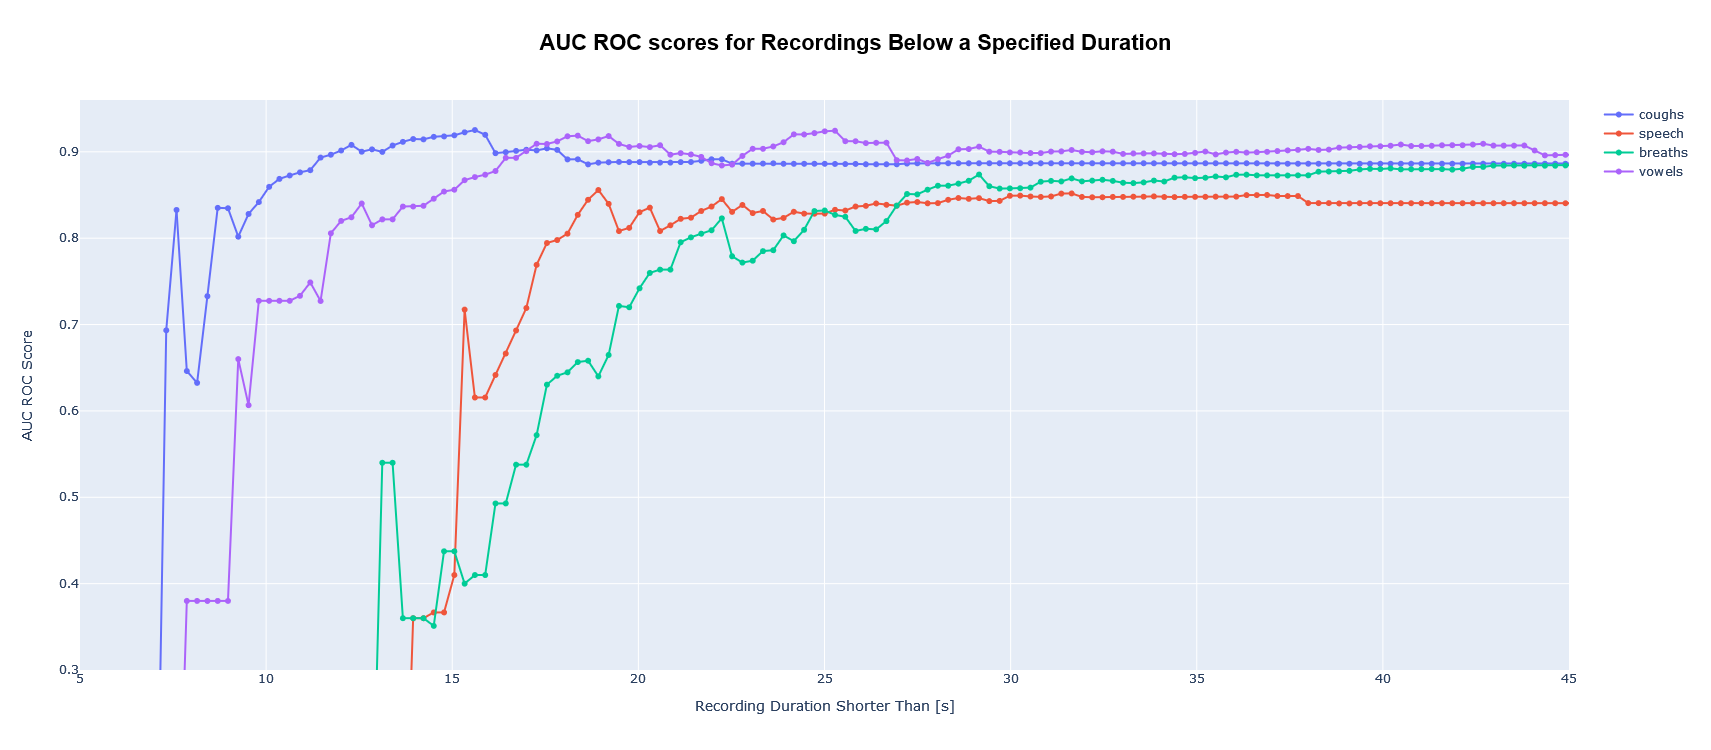

In [402]:
set_types = [
    "test",
    # "eval"
]
starting_point_sec = 4
durations = (0, starting_point_sec)
seconds = 45
time_axis = np.linspace(0, 55, 200)
fig = go.Figure()
for modality in use_modalities:
    temp_df = merged_df.copy()
    metrics = []
    if len(set_types) < 2:
        temp_df = temp_df[temp_df["set_type"] == set_types[0]]
    temp_df = temp_df[temp_df["rec_type"] == modality]
    for offset in time_axis:
        duration_col = [col for col in full_metadata.columns if (modality in col) and ("total_duration" in col)]
        duration_col = duration_col[0]
        duration_col
        # df = temp_df[temp_df[duration_col] > durations[0]+offset]
        # df = temp_df[temp_df[duration_col] < durations[1]+offset]
        df = temp_df[temp_df[duration_col] < offset]
        # df = temp_df[temp_df[duration_col] > offset]
        if len(df) > 10:
            aucroc = ju.get_aucroc(list(df.label), list(df.prediction))
            metrics.append(aucroc)
        else:
            metrics.append(0)
    trace = go.Scatter(x=time_axis+starting_point_sec, y=metrics, mode='lines+markers', name=modality.replace("combined_", ""))
    fig.add_trace(trace)

layout = go.Layout(
    title={
        'text': '<b>AUC ROC scores for Recordings Below a Specified Duration</b>',
        'x': 0.5,  # Center the title
        'xanchor': 'center',  # Center the title
        'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
    },
    xaxis=dict(title='Recording Duration Shorter Than [s]'),
    yaxis=dict(title='AUC ROC Score')
)
layout['height'] = 750  # You can adjust this value as needed
layout['width'] = 1500  # You can adjust this value as needed
fig.update_layout(layout)
fig.update_xaxes(range=[5, 45])  # Set the x-axis limits
fig.update_yaxes(range=[0.3, 0.96])   # Set the y-axis limits
fig.show()

In [416]:
set_types = [
    "test",
    # "eval"
]
fig = go.Figure()
for modality in use_modalities:
    aucroc_notest, aucroc_tested, total_aucroc = [],[],[]
    for seed in seeds:
        temp_df = merged_df.copy()
        temp_df = temp_df[temp_df["seed"] == seed]
        if len(set_types) < 2:
            temp_df = temp_df[temp_df["set_type"] == set_types[0]]
        temp_df = temp_df[temp_df["rec_type"] == modality]


        df_notest = temp_df[temp_df["type_of_covid_test"] != "rtpcr"]
        df_tested = temp_df[temp_df["type_of_covid_test"] == "rtpcr"]


        aucroc_notest.append(ju.get_aucroc(list(df_notest.label), list(df_notest.prediction)))
        aucroc_tested.append(ju.get_aucroc(list(df_tested.label), list(df_tested.prediction)))
        total_aucroc.append(ju.get_aucroc(list(temp_df.label), list(temp_df.prediction)))

        # aucroc_notest = ju.get_aucroc(list(df_notest.label), list(df_notest.prediction))
        # aucroc_tested = ju.get_aucroc(list(df_tested.label), list(df_tested.prediction))
        # total_aucroc = ju.get_aucroc(list(temp_df.label), list(temp_df.prediction))
    aucroc_notest, aucroc_tested, total_aucroc = np.mean(aucroc_notest),  np.mean(aucroc_tested),  np.mean(total_aucroc)
    print(f"modality: {modality}")
    print(f"Datasets Used: {set_types}")
    print(f"AUC ROC for untested Participants (count: {len(df_notest.ID.value_counts())}):   {round(aucroc_notest*100, 1)}% \nAUC ROC for tested Participants   (count: {len(df_tested.ID.value_counts())}):    {round(aucroc_tested*100,1)}%  \nAUC ROC for all Participants   (count: {len(temp_df.ID.value_counts())}):    {round(total_aucroc*100,1)}%")
# trace = go.Scatter(x=time_axis+starting_point_sec, y=metrics, mode='lines+markers', name=modality.replace("combined_", ""))
# fig.add_trace(trace)
# layout = go.Layout(
#     title={
#         'text': '<b>AUC ROC scores for Recordings Below a Specified Duration</b>',
#         'x': 0.5,  # Center the title
#         'xanchor': 'center',  # Center the title
#         'font': {'size': 22, 'color': 'black', 'family': 'Arial'}
#     },
#     xaxis=dict(title='Recording Duration Shorter Than [s]'),
#     yaxis=dict(title='AUC ROC Score')
# )
# layout['height'] = 750  # You can adjust this value as needed
# layout['width'] = 1500  # You can adjust this value as needed
# fig.update_layout(layout)
# fig.update_xaxes(range=[5, 45])  # Set the x-axis limits
# fig.update_yaxes(range=[0.3, 0.96])   # Set the y-axis limits
# fig.show()

modality: combined_coughs
Datasets Used: ['test']
AUC ROC for untested Participants (count: 445):   85.2% 
AUC ROC for tested Participants   (count: 21):    95.3%  
AUC ROC for all Participants   (count: 466):    89.0%
modality: combined_speech
Datasets Used: ['test']
AUC ROC for untested Participants (count: 442):   84.0% 
AUC ROC for tested Participants   (count: 21):    93.5%  
AUC ROC for all Participants   (count: 463):    87.1%
modality: combined_breaths
Datasets Used: ['test']
AUC ROC for untested Participants (count: 440):   89.0% 
AUC ROC for tested Participants   (count: 13):    58.7%  
AUC ROC for all Participants   (count: 453):    88.5%
modality: combined_vowels
Datasets Used: ['test']
AUC ROC for untested Participants (count: 443):   86.9% 
AUC ROC for tested Participants   (count: 21):    72.1%  
AUC ROC for all Participants   (count: 464):    89.8%


In [409]:
temp_df

,ID,label,loss,prediction,rec_type,seed,set_type,combined_coughs_total_duration,combined_speech_total_duration,combined_breaths_total_duration,combined_vowels_total_duration,age,country,gender,type_of_covid_test
3019,08tlSbvXpAggZavIGW994adhh1m1,1.0000,0.5669,0.5133,combined_vowels,99468865,test,8.6500,24.4160,15.6910,41.7290,37,India,male,rtpcr
3020,0c00ybTdnIRUTXeg20bZjJOzhKv1,0.0000,0.6818,0.4943,combined_vowels,99468865,test,11.0290,13.0840,22.9640,13.8980,30,India,male,NaN
3021,0KOy96zEUfdMY4rZzwrDT0gMPDa2,0.0000,0.6798,0.4933,combined_vowels,99468865,test,9.5360,21.2700,41.8130,42.2510,22,United States,male,NaN
3022,0kQAWAGJHffg9kZhji65QkUaEvx1,0.0000,0.6814,0.4941,combined_vowels,99468865,test,9.1950,18.9220,15.2000,26.9770,40,India,male,NaN
3023,0VpjgRGE5kR8uTEhksBgvFR3xlA2,0.0000,0.6791,0.4929,combined_vowels,99468865,test,4.5970,18.4850,27.7970,25.1630,27,India,male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3478,ZNTuppbDaCNybeDYGmyjJeYr93s1,0.0000,0.6991,0.5030,combined_vowels,99468865,test,14.4960,22.8270,28.3740,48.9380,27,India,female,NaN
3479,zOmz0TaNdmQfF2jUFkqUKuNa80m1,0.0000,0.6741,0.4904,combined_vowels,99468865,test,5.5780,19.5630,26.4320,20.4790,29,India,male,NaN
3480,Zs7tQ487P7hws3ur1TG53aiF0eC2,0.0000,0.6832,0.4950,combined_vowels,99468865,test,9.3550,21.0780,20.8420,49.5570,23,India,male,NaN
3481,Zs8oTVcUPTc8pk9UES7sFEhRDxX2,0.0000,0.6822,0.4945,combined_vowels,99468865,test,8.7360,26.2620,25.0140,18.5600,27,India,male,NaN


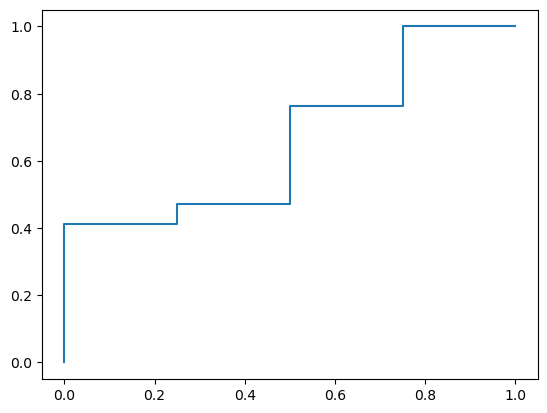

In [404]:

roc_notest = roc_curve(list(df_notest.label), list(df_notest.prediction))
roc_tested = roc_curve(list(df_tested.label), list(df_tested.prediction))
roc_total = roc_curve(list(temp_df.label), list(temp_df.prediction))

tpr, fpr, _ = roc_tested
_ = plt.plot(tpr, fpr)


In [405]:
df_tested

,ID,label,loss,prediction,rec_type,seed,set_type,combined_coughs_total_duration,combined_speech_total_duration,combined_breaths_total_duration,combined_vowels_total_duration,age,country,gender,type_of_covid_test
14,373AihVhKDYxeUR24zNi11JavqC3,1.0000,0.2773,0.7578,combined_vowels,66445511337,eval,8.9380,33.3540,31.9460,33.4290,26,India,female,rtpcr
30,4h4p5SvPlHaV60UB1wA0uzaQwMt1,0.0000,0.4860,0.3848,combined_vowels,66445511337,eval,6.3250,22.7200,15.8400,28.0750,37,India,male,rtpcr
32,5lJ84fQKn6PXGe3eKwkd3LRquum2,0.0000,0.8992,0.5931,combined_vowels,66445511337,eval,15.7550,31.0930,29.7280,34.9440,63,India,male,rtpcr
33,5tVbqoDLs6PZKArvhcMTZcgxruo1,1.0000,0.1005,0.9044,combined_vowels,66445511337,eval,5.5150,26.7410,20.3940,35.8830,41,India,male,rtpcr
35,6aOGyUJRIcXSEWNRCkzUodJimux1,1.0000,0.4334,0.6485,combined_vowels,66445511337,eval,6.7840,27.2640,18.8910,21.1200,65,India,female,rtpcr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13773,XpMEOhbTdsSYUjo2zsmVjnVOsoK2,1.0000,0.1509,0.7776,combined_breaths,99468865,eval,8.3840,27.7010,26.5280,45.0460,52,India,male,rtpcr
13775,Y0K7dqxP7WWsIjth3NfIHU9ayKO2,1.0000,0.2069,0.7083,combined_breaths,99468865,eval,3.3280,25.8780,15.7120,9.1410,20,India,male,rtpcr
13779,yeP1km1hb2Z9xtf7ZVQxzOFECVw1,1.0000,0.8056,0.2611,combined_breaths,99468865,eval,9.9420,26.8800,20.1390,43.1790,17,India,male,rtpcr
13780,ygiPwZYsKFetOejhxWXB6rKSHAf2,1.0000,0.3663,0.5431,combined_breaths,99468865,eval,9.7920,25.4720,19.2100,7.4130,66,India,male,rtpcr


In [406]:
950/20

47.5